<div style="text-align: center;">
    <img src="images/Polito logo.png" width="500">
</div>

## Dipartimento di Ingegneria Gestionale e della Produzione
## Laurea Triennale in Ingegneria Gestionale - Classe L8
## A.A 2024 / 2025

# Applicazione della teoria dei grafi per l’ottimizzazione di portafogli finanziari

### Studente proponente
RONALDO RADU MOISEI

### Matricola
284773

### Relatore
Prof. AVERTA GIUSEPPE BRUNO

<div style="page-break-after: always;"></div>


## 1) Descrizione del problema presentato

In questo progetto si studia come costruire portafogli azionari che rispettino vincoli pratici di gestione: numero massimo di titoli in portafoglio, presenza minima di emittenti considerati “affidabili” e limiti sui pesi di ogni titolo. L’idea di base è combinare il classico modello media-varianza con strumenti presi dalla teoria dei grafi.

L’universo iniziale è formato da titoli dell’S&P 500. A partire da questo insieme si costruiscono portafogli coerenti con il profilo di rischio dell’investitore, cercando di ottenere una buona diversificazione rispetto alle correlazioni storiche tra i rendimenti e monitorando la qualità del credito delle imprese, distinguendo tra titoli con rating e titoli senza rating.

Nel lavoro sono state identificate due famiglie principali di soluzioni basate sul concetto di “portafoglio su grafo”:

1. un portafoglio a minima varianza con vincoli realistici sui pesi e sulla cardinalità;
2. portafogli “decorrelati” costruiti usando il grafo delle distanze tra i titoli.

La gestione dei titoli privi di rating è emersa come uno dei punti più delicati. La variabile “unrated” non rimane una semplice etichetta descrittiva, ma diventa un vero vincolo quantitativo da rispettare nella costruzione del portafoglio.

### 1.1 Descrizione dell’importanza gestionale del problema

Dal punto di vista gestionale, il progetto propone uno strumento che non si limita a ridurre la varianza del portafoglio, ma integra anche:

- vincoli sulla qualità media del portafoglio (numero massimo di titoli non classificati, rating medio minimo);
- requisiti operativi (cardinalità K, peso minimo per titolo);
- controllo della correlazione tramite un grafo delle distanze.

In questo modo è possibile ridurre la concentrazione, limitare l’esposizione a titoli poco trasparenti e adattare la quota di titoli “unrated” al profilo di rischio scelto. Il sistema produce due portafogli da confrontare: un portafoglio a minima varianza e un portafoglio a massima decorrelazione.

In una fase iniziale la teoria dei grafi è stata usata soprattutto come strumento esplorativo, per analizzare cluster, centralità e comunità nel network dei titoli. Con il procedere del lavoro, però, l’uso più utile dal punto di vista gestionale si è rivelato quello del grafo come filtro per selezionare l’universo dei titoli e come base per costruire portafogli con bassa correlazione interna. Le analisi di centralità e raggruppamento restano interessanti a livello teorico, ma sono state messe in secondo piano rispetto ad applicazioni operative più immediate, come:

- selezione di K titoli;
- gestione dei vincoli tra titoli con rating e senza rating;
- confronto tra diverse tipologie di portafoglio (minima varianza vs decorrelato).

### 1.2 Descrizione iniziale degli algoritmi coinvolti

Il progetto integra più blocchi algoritmici all’interno di un unico modello (Model) e delle relative classi di supporto (DAO, RiskEstimator, GraphBuilder, PortfolioSelector, PortfolioWeights).

#### 1.2.1 Costruzione di correlazioni e distanze

Il flusso di base per passare dai dati grezzi al grafo è il seguente:

1. calcolo dei rendimenti logaritmici giornalieri;
2. stima di $\mu$ (rendimenti medi) e $\Sigma$ (covarianza) su tutto l’orizzonte temporale disponibile;
3. costruzione della matrice di correlazione $\rho$;
4. definizione di una matrice delle distanze $D = (d_{ij})$, tipicamente con
   $$d_{ij} = 1 - |\rho_{ij}|$$
   nella versione non firmata, oppure con varianti “signed” per distinguere correlazioni positive e negative.

Le informazioni vengono riassunte in due oggetti principali:

- la matrice delle distanze $D$, usata per costruire il grafo e identificare percorsi “a bassa correlazione”;
- la matrice di covarianza $\Sigma$, usata nei problemi di minima varianza.

In questo modo il livello statistico ($\mu$, $\Sigma$) è collegato in modo diretto al livello di rete ($D$, grafo) all’interno di un flusso coerente.

#### 1.2.2 Filtraggio del grafo e definizione dell’universo ristretto U'

A partire da $D$, la classe GraphBuilder costruisce un grafo pesato in NetworkX in cui:

- i nodi rappresentano i titoli;
- gli archi collegano coppie di titoli con distanza finita, con peso pari a $d_{ij}$.

Sul grafo grezzo si applicano alcuni filtri per ridurre rumore e densità:

- una soglia sulla correlazione (o sulla distanza);
- un filtro k-NN, che per ogni titolo mantiene solo i $k$ vicini “più simili”.

L’universo ristretto $U'$ dei titoli candidati nasce dalla combinazione di:

- criteri quantitativi (volatilità, rendimento atteso, rating);
- struttura del grafo filtrato (escludendo titoli troppo isolati o ridondanti).

Invece di usare algoritmi come BFS/DFS per generare direttamente i portafogli a partire dai cluster, si è scelto un approccio in due step:

1. usare il grafo come filtro strutturale (soglia + k-NN) per definire un $U'$ compatto;
2. delegare la selezione combinatoria a una procedura ricorsiva ottimizzata.

#### 1.2.3 Gestione del mix rated/unrated

Ogni titolo viene classificato come “rated” o “unrated” in base alla presenza di un rating creditizio. Per ogni profilo di rischio sono impostati alcuni parametri, tra cui:

- quota massima di peso totale assegnabile a titoli non classificati (`max_unrated_share`);
- valore minimo del rating medio ponderato del portafoglio (`min_rating_score`).

Questi vincoli vengono controllati sia in fase di selezione dei titoli, sia in fase di calcolo dei pesi. Se non sono rispettati, la combinazione candidata viene scartata.

Senza vincoli chiari, il modello tendeva a includere una quota elevata e poco controllata di titoli non classificati. Questo ha reso necessario introdurre limiti stringenti sia sulla quota di titoli “unrated” sia sul rating medio. Di fatto, l’informazione sul rating è passata da semplice etichetta descrittiva a requisito quantitativo centrale.

#### 1.2.4 Vincolo di peso minimo $1/(2K)$ nel portafoglio a minima varianza

Il portafoglio di riferimento viene costruito con un modello media-varianza che bilancia rendimento atteso e rischio. A questo schema classico sono stati aggiunti vincoli operativi che guidano l’allocazione. I principali sono:

- vincolo di budget (somma dei pesi = 1);
- non negatività dei pesi (no short selling);
- cardinalità fissata a K titoli;
- peso minimo per ogni titolo selezionato:
  $$w_{\min} = \frac{1}{2K}.$$

Il vincolo sul peso minimo è il più rilevante dal punto di vista pratico. Senza questo limite, il modello tende a concentrare gran parte del capitale su pochi titoli, lasciando gli altri con peso nullo. Imporre $w_{\min} = 1/(2K)$ obbliga a una diversificazione minima tra i titoli scelti.

#### 1.2.5 Ricorsione per la selezione combinatoria e ottimizzazioni

La scelta di $K$ titoli dall’insieme $U'$ sotto vincoli di rischio, rating e composizione è un problema combinatorio. Per affrontarlo si utilizza una procedura ricorsiva con backtracking.

L’idea è costruire il portafoglio passo dopo passo. A ogni livello:

- si controllano subito i vincoli più semplici (numero di titoli, quota di “unrated”, rating medio);
- si stima un limite superiore sul punteggio massimo ancora raggiungibile, in modo da capire se vale la pena continuare a esplorare quella diramazione (logica di Branch & Bound).

Per ridurre i tempi di calcolo sono state introdotte alcune ottimizzazioni:

- pre-filtro quantitativo su $U'$ per ridurre la dimensione del problema;
- costruzione di una soluzione iniziale “greedy” da usare come seed e come limite superiore;
- Branch & Bound completo, con aggiornamento sistematico dei bound per tagliare rami poco promettenti;
- uso di NumPy per le parti numeriche più pesanti, in modo da limitare l’overhead di Python puro.

#### 1.2.6 Algoritmo di Dijkstra per portafogli decorrelati

Sul grafo delle distanze si sceglie un nodo iniziale e si applica l’algoritmo di Dijkstra per calcolare i percorsi minimi verso gli altri nodi. L’obiettivo non è tanto la “distanza minima” in senso classico, quanto la possibilità di selezionare titoli che si trovano su percorsi caratterizzati da archi con distanza elevata, cioè bassa correlazione.

In questo modo si costruisce un sottoinsieme di titoli che, per costruzione, sono meno correlati tra loro. Su questo insieme ridotto si calcolano poi i pesi ottimali con lo stesso schema di minima varianza, mantenendo il vincolo sul peso minimo e i vincoli sul mix rated/unrated.

Per facilitare il confronto con il portafoglio classico a minima varianza, il lavoro si concentra su questo singolo metodo basato su Dijkstra. Altri approcci di network filtering e portfolio construction (come MST, PMFG o metodi di *community detection*) vengono lasciati come possibili sviluppi futuri per rafforzare ulteriormente la decorrelazione.

#### 1.2.7 Simulazione Monte Carlo sui portafogli ottimali

Per ogni combinazione di profilo di rischio, valore di $K$ e tipo di portafoglio (minima varianza o decorrelato) è stato implementato un modulo di simulazione Monte Carlo. A partire da $\mu$ e $\Sigma$ stimati si generano scenari simulati su più periodi, con l’obiettivo di osservare la distribuzione del capitale finale su orizzonti di 10, 20 e 30 anni.

I risultati delle simulazioni vengono riassunti tramite:

- grafici delle distribuzioni simulate;
- valori attesi del capitale finale;
- quantili (ad esempio 5%, 50%, 95%);
- probabilità di superare determinate soglie.

Per limiti di tempo il modello non include aspetti più complessi, come distribuzioni non gaussiane, volatilità stocastica o ribilanciamenti dinamici del portafoglio. Questi elementi rappresentano possibili estensioni future.

### 1.3 Descrizione iniziale delle funzionalità previste per l’applicazione software

L’applicazione è stata sviluppata come interfaccia desktop in Python usando la libreria Flet, seguendo un’architettura Model–View–Controller per separare logica, interfaccia e gestione dei dati.

Dal punto di vista dell’utente, il flusso di utilizzo è il seguente:

1. Inserimento dei dati di base:
   - capitale iniziale;
   - numero massimo di titoli in portafoglio ($K$).
2. Scelta del profilo di rischio (basso, medio, alto), che imposta automaticamente:
   - la quota massima di titoli non classificati (*unrated*);
   - il punteggio minimo di rating medio;
   - altri parametri tecnici dell’ottimizzazione.

A partire da queste informazioni, il software costruisce due portafogli:

- un portafoglio a minima varianza, con vincolo di peso minimo pari a $1/(2K)$;
- un portafoglio “decorrelato”, selezionato tramite il grafo delle distanze e l’algoritmo di Dijkstra.

Per entrambi vengono mostrate:

- la composizione dei pesi;
- le statistiche sul rating;
- gli indicatori di rischio e rendimento.

Dopo la costruzione dei portafogli è possibile lanciare la simulazione Monte Carlo su orizzonti di 10, 20 o 30 anni. I grafici generati vengono salvati automaticamente in una cartella dedicata per facilitare il confronto tra scenari e portafogli.

L’applicazione gestisce anche i casi in cui i vincoli sono troppo restrittivi. Se non è possibile costruire un portafoglio valido, viene mostrato un messaggio di errore che invita l’utente a rilassare alcuni parametri (ad esempio aumentare K o ridurre i vincoli sul rating). È presente inoltre un sistema di log per monitorare i tempi di calcolo e le fasi principali dell’elaborazione.

<div style="page-break-after: always;"></div>

## 2. Descrizione del problema trattato

### 2.1 Contesto operativo e aziendale

Nel modello di **Markowitz**, un portafoglio definito dai pesi $w$ (tali che $\sum_i w_i=1$) è caratterizzato da un rendimento atteso $m^{\top} w$ e da una varianza $w^{\top}\Sigma w$. Il problema del portafoglio a **minima varianza** si formula come segue:

$$
\min_{w} \frac{1}{2} w^{\top} \Sigma w
\quad s.t. \quad m^{\top} w \geq \mu_b, \quad e^{\top} w = 1
$$

Dove $e$ è il vettore unitario e $\mu_b$ rappresenta il rendimento minimo accettabile. Poiché la matrice di covarianza $\Sigma$ e il vettore dei rendimenti attesi $m$ non sono osservabili, è necessario stimarli. Tuttavia, la covarianza campionaria può essere disturbata da rumore e collinearità. Per ovviare a questo problema, si utilizza uno **stimatore shrinkage**: la matrice stimata si ottiene come una combinazione convessa tra la matrice empirica $\widehat{\Sigma}$ e una matrice target $T$ (ad esempio diagonale). La formula è $\Sigma_{\text{sh}} = (1-\lambda)\widehat{\Sigma} + \lambda\mu I$, dove $\mu = \operatorname{trace}(\widehat{\Sigma})/n$ rappresenta la media delle varianze marginali. Il **parametro di shrinkage** $\lambda\in[0,1]$ regola quanto peso dare alla struttura campionaria: se $\lambda=0$ si usa la matrice empirica pura, se $\lambda=1$ si riduce tutto a una matrice diagonale.

Nel contesto di questo lavoro, l'analisi si basa su un universo di centinaia di azioni statunitensi, arricchito da un dataset di **rating creditizi**. Ogni titolo possiede un rating alfabetico (da AAA a D), che viene convertito in un punteggio numerico su scala 1-22. Le definizioni (come quelle di Fitch) distinguono tra titoli **investment grade** (es. AAA, che indica minima probabilità di default) e titoli **speculativi** (BB/B) o prossimi al default (CCC–C). Oltre a ottimizzare rischio e rendimento, la costruzione del portafoglio deve rispettare vincoli specifici: diversificazione settoriale, limiti sulla quota di titoli senza rating (*unrated*), soglie per il rating medio e restrizioni sulla correlazione tra i titoli.


## 2. Descrizione del problema trattato

### 2.1 Contesto operativo e aziendale

Il punto di partenza è il modello classico di **Markowitz**, in cui un portafoglio è descritto da un vettore di pesi (w), con vincolo (\sum_i w_i = 1). A ogni scelta di (w) corrispondono:

* un rendimento atteso (m^{\top} w);
* una varianza (w^{\top} \Sigma w), dove (\Sigma) è la matrice di covarianza dei rendimenti.

Il problema del portafoglio a **minima varianza**, con un rendimento minimo richiesto, può essere scritto come:

[
\min_{w} \frac{1}{2} w^{\top} \Sigma w
\quad \text{soggetto a} \quad
m^{\top} w \geq \mu_b, \quad
e^{\top} w = 1,
]

dove (e) è il vettore di tutti 1 e (\mu_b) è il rendimento minimo accettabile.

Nella pratica, né (\Sigma) né (m) sono noti. Vengono stimati dai dati storici, ma la covarianza campionaria è spesso instabile: soffre il rumore, la collinearità, e diventa poco affidabile quando il numero di titoli è grande rispetto al numero di osservazioni. Per stabilizzare la stima si usa uno **stimatore shrinkage**, cioè una media tra la matrice empirica (\widehat{\Sigma}) e una matrice “più semplice” (ad esempio diagonale):

[
\Sigma_{\text{sh}} = (1-\lambda),\widehat{\Sigma} + \lambda,\mu I,
]

dove (\mu = \operatorname{trace}(\widehat{\Sigma})/n) è la media delle varianze sulla diagonale, e (\lambda \in [0,1]) controlla quanto “si spinge” la matrice verso la forma diagonale. Se (\lambda=0) si usa la covarianza empirica pura, se (\lambda=1) si ottiene una matrice solo diagonale, che ignora le correlazioni.

In questo lavoro applichiamo il modello a un universo di alcune centinaia di azioni statunitensi, arricchito da un dataset di **rating creditizi**. Ogni titolo ha un rating alfabetico (da AAA a D), che viene tradotto in un punteggio numerico su scala 1–22. Le categorie più alte (AAA, AA, A, BBB) corrispondono a titoli **investment grade**, con bassa probabilità di default. Le categorie più basse (BB, B, CCC–C, D) indicano titoli **speculativi** o già in default o prossimi al default.

L’obiettivo non è solo trovare un buon compromesso rischio–rendimento, ma anche rispettare vincoli operativi e di rischio aggiuntivi. In particolare:

* soglie sul rating medio del portafoglio;
* limiti alla quota di titoli senza rating (*unrated*);
* vincoli di diversificazione per settore;
* limiti sulla correlazione tra i titoli.

In questo modo il portafoglio risultante è pensato per essere utilizzabile in un contesto reale, ad esempio da un fondo o da un investitore istituzionale con politiche di rischio definite.

---

### 2.2 Sotto-problema selezionato e flusso logico

Nel lavoro ci concentriamo su un sotto-problema concreto: data una base dati ampia, vogliamo selezionare un portafoglio di dimensione fissa (K) che massimizzi uno **score complessivo**, rispettando una serie di vincoli.

I vincoli principali sono:

* una percentuale minima di titoli con rating elevato (≥ `rating_min`);
* una percentuale massima di titoli senza rating (`max_unrated_share`);
* un limite alla correlazione assoluta tra coppie di titoli ((|\rho_{ij}| \leq \rho_{\text{pair_max}}));
* una quota massima per ogni settore (`max_share_per_sector`);
* un peso minimo per ciascun titolo (w_{\min} = 1/(2K)).

Per arrivare al portafoglio finale, il codice segue un flusso di passi ben definiti.

#### 1. Caricamento dei dati e modellazione degli asset

Il modulo `DAO` legge i file CSV e, per ogni ticker, costruisce un oggetto `Stock`. Ogni oggetto contiene:

* serie storiche dei prezzi di chiusura;
* rendimenti logaritmici;
* punteggio di rating (numerico);
* settore di appartenenza;
* un flag che indica se il titolo ha rating o è *unrated*.

In questo modo la logica di caricamento rimane isolata e il resto del modello lavora su oggetti `Stock` già “preparati”.

#### 2. Valutazione dei parametri di rischio

A questo punto i dati grezzi vengono trasformati in input per il modello.

* **Pulizia dei dati.**
  Si calcolano i rendimenti logaritmici giornalieri. Per ridurre l’impatto dei valori estremi si applica la *winsorizzazione* tra i quantili `winsor_lower` e `winsor_upper`. Le serie con troppi valori mancanti vengono scartate; dove i mancanti sono pochi, vengono sostituiti con la media della colonna.

* **Stima della covarianza.**
  Con le serie pulite si calcola la covarianza empirica (\widehat{\Sigma}), che viene poi “corretta” con lo shrinkage:
  [
  \Sigma_{\text{sh}} = (1-\lambda),\widehat{\Sigma} + \lambda,\mu I.
  ]
  L’aggiunta della componente diagonale migliora la stabilità numerica e rende la matrice più adatta per l’ottimizzazione.

* **Correlazioni e rendimenti attesi.**
  Da (\Sigma_{\text{sh}}) si ricava la matrice di correlazione (\rho). Il vettore dei rendimenti attesi (\mu) viene stimato come media campionaria dei rendimenti. Modificando alcuni parametri è possibile studiare scenari diversi (più o meno volatili, con correlazioni più o meno marcate).

#### 3. Costruzione del grafo di correlazione e universo ridotto (U')

Per analizzare le relazioni tra titoli usiamo un **grafo**. A partire dalla matrice di correlazione, costruiamo una matrice delle **distanze** (D):

[
d_{ij} = 1 - |\rho_{ij}|
\quad \text{o} \quad
d_{ij} = \frac{1 - \rho_{ij}}{2},
]

a seconda che si voglia tener conto anche del segno della correlazione.

Su questa matrice si applicano due filtri:

* un **filtro a soglia** basato su (\tau): se (|\rho_{ij}| < \tau), il collegamento tra i due titoli viene eliminato;
* un **filtro k-NN** (k-nearest neighbors): per ogni titolo si mantengono solo i (k) legami più forti, in termini di distanza più bassa.

In parallelo, si costruisce l’universo ridotto (U') filtrando i titoli in base a:

* rating minimo;
* quota massima di *unrated*;
* dimensione massima `max_size`.

L’insieme (U') è l’universo investibile “pulito” su cui lavorano gli algoritmi combinatori.

#### 4. Selezione combinatoria (Branch & Bound)

Dall’universo (U') vogliamo estrarre (K) titoli che massimizzino uno score complessivo. Il problema è combinatorio e cresce molto rapidamente con il numero di titoli. Per gestirlo si utilizza un algoritmo di tipo **Branch & Bound**.

I passaggi principali sono:

* **Pre-selezione.**
  Per ogni titolo si calcola uno *score* iniziale, che combina rendimento, volatilità e rating. I titoli peggiori vengono scartati subito, riducendo lo spazio di ricerca.

* **Ricerca con vincoli.**
  L’algoritmo costruisce portafogli parziali, verificando via via i vincoli su pesi minimi, rating medio, quota di *unrated* e limiti settoriali. Se un portafoglio parziale non potrà mai portare a uno score migliore di quello corrente, il ramo viene tagliato.

La funzione obiettivo per un portafoglio (S) è:

[
score(S) = \alpha(-\bar{\rho}) + \beta \bar{r} - \gamma ,\text{penalità}_{\text{settori}} + \delta \bar{\mu},
]

dove:

* (\bar{\rho}): correlazione media tra i titoli del portafoglio;
* (\bar{r}): rating medio;
* (\bar{\mu}): rendimento atteso medio;
* (\alpha, \beta, \gamma, \delta): parametri che pesano decorrelazione, qualità del credito, diversificazione settoriale e rendimento.

Come punto di partenza si costruisce anche una soluzione iniziale con un metodo *greedy*, che fornisce un primo bound da superare.

#### 5. Calcolo dei pesi

Una volta scelti i (K) titoli, si passa a decidere “quanto” investire su ciascuno.

Le logiche adottate sono due:

* **Equal-weight.**
  Tutti i titoli hanno lo stesso peso (1/K). È una scelta semplice e spesso robusta.

* **Mean-variance.**
  Si risolve un problema alla Markowitz, con vincoli di somma unitaria e peso minimo (w_{\min}=1/(2K)). Per evitare problemi numerici si introduce una regolarizzazione di tipo *ridge* sulla matrice di covarianza. I pesi ottenuti vengono poi arrotondati e riscalati per rispettare il budget totale.

#### 6. Portafoglio de-correlato tramite Dijkstra

Accanto al portafoglio combinatorio, si costruisce un portafoglio alternativo usando l’algoritmo di **Dijkstra** sul grafo delle distanze. L’idea è selezionare titoli che siano “lontani” dal punto di vista della correlazione.

La procedura è la seguente:

1. si sceglie un titolo di partenza, di solito quello con peso maggiore nel portafoglio di minima varianza;
2. si applica Dijkstra usando (d_{ij} = 1 - |\rho_{ij}|) come costo;
3. si analizzano le distanze minime dal nodo sorgente e si selezionano, progressivamente, i titoli più distanti, fino a raggiungere (K) nomi.

Anche in questo caso i pesi sono calcolati secondo le logiche del punto precedente, così da poter confrontare i due portafogli sulla stessa base.

#### 7. Simulazioni Monte Carlo

Per valutare il comportamento futuro dei portafogli si usano simulazioni **Monte Carlo**, assumendo che i prezzi seguano, in prima approssimazione, un processo log-normale.

I passaggi sono:

* si fissano `n_paths` (numero di scenari) e `n_days` (orizzonte temporale);
* si utilizzano la media e la volatilità del portafoglio per generare, per ogni scenario, una traiettoria possibile del valore nel tempo;
* al termine si analizzano statistiche riassuntive.

Gli output tipici sono:

* traiettoria media;
* valore atteso finale;
* deviazione standard degli esiti;
* quantili (ad esempio 5°, 50° e 95° percentile);
* probabilità di perdita, ad esempio (P(V_T < 1)) o rispetto ad altre soglie definite dall’utente.

---

### 2.3 Principali input

Il modello richiede diversi input, sia di tipo “dati” sia di tipo “parametri”. Possiamo raggrupparli per funzionalità.

**Prezzi e rendimenti.**
Si parte da un DataFrame con struttura (date × ticker) contenente i prezzi di chiusura. Da qui si ottengono i rendimenti logaritmici. Alcuni parametri controllano la qualità del dato:

* `min_non_na_ratio`: quota minima di osservazioni non mancanti per includere un titolo;
* `winsor_lower`, `winsor_upper`: quantili per la winsorizzazione (ad esempio 1% e 99%).

**Valutazione (rating).**
È necessario un dataset che, per ogni ticker, riporti:

* settore;
* rating alfabetico;
* data del rating.

I rating alfabetici vengono mappati in valori numerici 1–22. I parametri principali sono:

* `rating_min`: qualità minima accettata;
* `max_unrated_share`: quota massima di titoli senza rating ammessa sia in (U') sia nel portafoglio finale.

**Parametri di filtro e dimensione.**

* (\tau): soglia sulla correlazione assoluta (|\rho|); se (|\rho| < \tau), il collegamento viene rimosso;
* (k): numero di vicini mantenuti nel filtro k-NN;
* `max_size`: dimensione massima dell’universo ridotto (U').

Il **profilo di rischio** raccoglie le impostazioni più strategiche: imposta automaticamente i pesi dello score ((\alpha, \beta, \gamma, \delta)), la correlazione massima tra coppie (`rho_pair_max`) e i limiti di concentrazione settoriale (`max_share_per_sector`). Un profilo “conservativo” privilegia rating elevati e bassa correlazione, abbassando la quota di *unrated*. Un profilo “aggressivo” dà più spazio al rendimento e tollera correlazioni più elevate.

**Selezione combinatoria.**

* `K`: numero di titoli in portafoglio;
* `weight_mode`: scelta tra pesi uguali e pesi mean-variance;
* `mv_risk_aversion`: parametro di avversione al rischio nel problema di Markowitz;
* (w_{\min} = 1/(2K)): peso minimo per titolo.

**Simulazione Monte Carlo.**

* `n_paths`: numero di scenari simulati;
* `n_days`: durata in giorni dell’orizzonte di simulazione;
* `seed_bb`, `seed_dij`: semi per rendere riproducibili la selezione combinatoria e la costruzione del portafoglio Dijkstra.

---

### 2.4 Risultati attesi

L’implementazione produce diversi output, che descrivono sia lo spazio di partenza sia i portafogli selezionati.

**Universo ridotto (U').**
Si ottiene innanzitutto l’elenco dei ticker che superano i filtri su rating, correlazione e dimensione. La cardinalità di (U') dipende da (\tau), (k), `max_size`, `rating_min`, `max_unrated_share`. Questo insieme è il “campo di gioco” su cui operano gli algoritmi successivi.

**Grafo filtrato.**
Il modello restituisce la matrice di adiacenza del grafo, dove il peso dell’arco tra due titoli è (|\rho_{ij}|). Ogni arco conserva:

* `corr`: la correlazione (\rho_{ij});
* `distance`: la distanza (1 - |\rho_{ij}|) (oppure ((1-\rho_{ij})/2) nella versione con segno).

Questa struttura alimenta sia il Branch & Bound (per alcuni vincoli di correlazione) sia l’algoritmo di Dijkstra.

**Portafoglio ottimale (Branch & Bound).**
Il risultato principale è l’insieme di (K) titoli che massimizza lo score. Per questo portafoglio vengono resi disponibili:

* i pesi (equal-weight o mean-variance);
* lo score complessivo;
* la scomposizione dello score nelle sue componenti: decorrelazione, rating, penalità settoriale, rendimento.

**Portafoglio Dijkstra.**
Viene prodotto anche un portafoglio alternativo, costruito scegliendo i titoli più lontani nel grafo rispetto a un nodo di partenza. Anche qui si riportano i pesi e indicatori come:

* correlazione media;
* varianza;
* eventuale score associato.

Il confronto tra i due portafogli permette di capire quanto la struttura di correlazione influisca sulla composizione finale.

**Statistiche Monte Carlo.**
Per ogni portafoglio, le simulazioni Monte Carlo producono:

* la matrice con tutte le traiettorie simulate;
* la traiettoria media;
* il valore atteso finale del capitale;
* la deviazione standard;
* i quantili (5°, 50° e 95° percentile);
* la stima della probabilità di perdita rispetto a soglie predefinite.

Queste misure sintetizzano il profilo rischio–rendimento degli output del modello.

---

### 2.5 Criticità, potenzialità e significato

L’analisi del modello mette in evidenza alcuni punti critici, ma anche diversi margini di utilizzo e personalizzazione.

#### Criticità

La prima criticità è la **stima dei parametri** (\Sigma) e (\mu). La covarianza campionaria, in presenza di molti titoli, può risultare non definita positiva e molto sensibile al rumore. Lo shrinkage riduce il problema, ma la scelta di (\lambda) è centrale: valori troppo bassi lasciano la matrice “sporco di rumore”, valori troppo alti appiattiscono le differenze tra i titoli e cancellano parte dell’informazione sulle correlazioni.

Anche la fase di **pulizia dei dati** richiede attenzione. Winsorizzare troppo può tagliare eventi rari ma importanti; winsorizzare troppo poco lascia in circolo outlier molto influenti. Il parametro `min_non_na_ratio` va scelto in modo da garantire serie sufficientemente lunghe senza ridurre troppo l’universo investibile.

Sul fronte del grafo, la scelta di (\tau) e (k) determina la **struttura della rete**. Un (\tau) alto produce grafi molto radi, che evidenziano solo i legami più forti ma rischiano di spezzare la rete. Un (\tau) basso lascia quasi tutto e può includere relazioni deboli o spurie. Anche (k) ha un ruolo simile: se è troppo basso il grafo si riduce quasi a un albero, se è troppo alto perde parte dell’effetto di filtraggio.

La **complessità computazionale** è un altro elemento chiave. Il numero di combinazioni (\binom{N}{K}) cresce molto rapidamente con (N). I pre-filtri e la soluzione iniziale *greedy* aiutano, ma con vincoli rigidi (ad esempio pochi *unrated* ammessi) il Branch & Bound può comunque richiedere tempi lunghi.

Infine, la stima dei **rendimenti attesi** (\mu) è intrinsecamente instabile. Per questo il modello prevede la possibilità di dare meno peso al rendimento (parametro `delta` nello score e `mv_risk_aversion` per la parte mean-variance), fino ad arrivare, se necessario, a soluzioni quasi del tutto guidate da rischio, rating e correlazioni. Anche la **simulazione Monte Carlo** ha limiti noti: l’ipotesi di normalità dei rendimenti non cattura le code pesanti e la volatilità variabile nel tempo, e va quindi interpretata come una semplificazione.

#### Potenzialità

Nonostante le criticità, il modello è molto flessibile. I **pesi dello score** (\alpha, \beta, \gamma, \delta) permettono di adattare il comportamento del sistema alle preferenze dell’investitore:

* aumentando (\alpha) si spinge verso portafogli più decorrelati;
* aumentando (\beta) si privilegia la qualità del credito;
* aumentando (\gamma) si penalizzano maggiormente le concentrazioni settoriali;
* aumentando (\delta) si sposta l’attenzione sui rendimenti attesi.

La **struttura del grafo**, controllata da (\tau) e (k), consente di esplorare scenari diversi, dai grafi molto filtrati a quelli più densi. Questo rende il modello uno strumento utile anche per analisi di tipo esplorativo sulla rete di correlazioni.

I **vincoli aziendali** (`max_unrated_share`, `rating_min`, limiti per settore) permettono di modellare politiche interne di rischio e requisiti regolamentari. Lo stesso framework può essere adattato a investitori con esigenze molto diverse tra loro, semplicemente cambiando parametri e soglie.

Infine, la combinazione di:

* selezione combinatoria,
* portafoglio basato su Dijkstra,
* simulazioni Monte Carlo,

offre una visione completa: dalla scelta dei titoli, alla struttura di correlazione, fino alla distribuzione possibile degli esiti futuri. In questo senso il modello non è solo un esercizio teorico, ma un prototipo di strumento operativo per la costruzione di portafogli azionari con vincoli di rating e decorrelazione.


## 3. Descrizione del data-set utilizzato per l’analisi

Il progetto utilizza principalmente due insiemi di dati eterogenei, integrati tramite un livello di accesso ai dati (DAO) e fasi di pulizia e matching:

1. **Prezzi storici azionari**
   * File CSV con prezzi giornalieri (Open, High, Low, Close, Volume) per un insieme di titoli riconducibile all’S&P 500, su un orizzonte di alcuni anni.
   * A partire da questi dati vengono calcolati i rendimenti logaritmici giornalieri, la media dei rendimenti e la matrice di covarianza/correlazione.
   * Il pre-processing include: rimozione di serie troppo corte, gestione di ticker duplicati o rinominati, allineamento temporale delle serie.

2. **Rating aziendali e profilo di rischio**
   * Dataset con rating creditizi e indicatori di bilancio per un insieme di società quotate.
   * I rating vengono normalizzati su una scala numerica comparabile e mappati per ticker (o per nome emittente) tramite procedure di join e cleaning (gestione di omonimie, differenze di denominazione, assenza di rating).
   * I titoli privi di rating vengono marcati come “unrated” e trattati separatamente in fase di selezione del portafoglio.

Su questi data-set vengono costruite le grandezze derivate usate dal modello:

* matrice di correlazione $\rho$ e matrice delle distanze $d_{ij}$ (ad es. $d_{ij} = 1 - |\rho_{ij}|$ o varianti signed),
* misure sintetiche di rischio (varianza, volatilità, Sharpe ratio) a livello di portafoglio,
* indicatori sul mix rated/unrated (quota percentuale, rating medio pesato).

Il lavoro si basa su due dataset pubblici in formato CSV, integrati in un unico universo di investimento. Il primo è il file “all_stocks_5yr.csv” (Kaggle), che contiene quotazioni giornaliere (Open, High, Low, Close, Volume) per 505 titoli azionari USA su un orizzonte di circa cinque anni, dal 2013-02-08 al 2018-02-07. A partire da questo file sono stati costruiti, per ciascun ticker, una serie storica di prezzi “close” omogenea per calendario e i rendimenti logaritmici giornalieri. Sono stati rimossi i titoli con storia troppo corta o con lacune eccessive, e si è ottenuta una matrice prezzi (date × ticker) utilizzata come base per il calcolo di media, volatilità, correlazioni e per la simulazione Monte Carlo.

Il secondo dataset è “corporateCreditRatingWithFinancialRatios.csv”, che raccoglie 7.805 osservazioni di rating aziendali con informazioni sulle principali metriche di bilancio (leverage, margini, redditività, cash flow) e metadati quali nome della società, ticker, settore (da SIC code) e agenzia di rating. Da questo file si è ricavato, per ogni ticker, un rating alfabetico consolidato, poi mappato in un punteggio numerico su scala discreta (AAA→22, …, D→1), e un settore aggregato. Il processo di data cleaning ha incluso l’eliminazione di osservazioni duplicate, la gestione di ticker mancanti o incoerenti e la selezione di un’unica osservazione per ciascun emittente (ad esempio l’ultima disponibile in termini di “Rating Date”).
I due dataset sono stati uniti mediante il ticker, ottenendo per ogni titolo del paniere storico un profilo completo di serie dei rendimenti, settore e punteggio di rating, che costituisce la base informativa per la costruzione del grafo di correlazione, la definizione dell’universo ridotto U′ e l’ottimizzazione combinatoria del portafoglio.

<div style="page-break-after: always;"></div>

## 4. Descrizione ad alto livello delle strutture dati e degli algoritmi utilizzati

### 4.1 Strutture dati principali

Il cuore della gestione dati ruota attorno alla classe `Stock`. Questo oggetto funge da contenitore per tutte le informazioni rilevanti di un singolo titolo: il ticker, il settore di appartenenza, il rating (sia in formato numerico che la data di assegnazione) e, naturalmente, le serie storiche dei prezzi e dei rendimenti.

La logica di base è incapsulata nel metodo `set_prices`. Quando viene fornita una serie di prezzi di chiusura ("close"), la classe si occupa di ordinarla temporalmente, convertire i valori in formato float e calcolare immediatamente i rendimenti logaritmici. Questo passaggio è fondamentale per avere dati pronti all'uso nelle fasi successive di stima del rischio.

```python
class Stock:
    def set_prices(self, prices: pd.Series) -> None:
        # Ordina la serie per data e si assicura che sia float
        prices = prices.sort_index().astype(float)
        self.prices = prices

        # Calcola log-prezzi e rendimenti logaritmici
        log_prices = prices.apply(np.log)
        self.returns = log_prices.diff()
```

Per recuperare i dati senza complicare la logica principale, si usa il `DAO` (Data Access Object). Questa classe gestisce la lettura dei file CSV grezzi e costruisce le strutture necessarie: un DataFrame per i prezzi (`prices_df`), uno per i rating (`ratings_df`) e infine un dizionario che mappa ogni ticker al suo oggetto `Stock`.

Il metodo `_load_prices` svolge il lavoro di pulizia iniziale: legge il file, converte le date e crea una tabella pivot dove le righe rappresentano i giorni e le colonne i singoli ticker.

```python
class DAO:
    def _load_prices(self) -> pd.DataFrame:
        df = pd.read_csv(self._prices_path)
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date")

        # Pivot: index = date, columns = ticker, values = close
        prices = df.pivot(index="date", columns="Name", values="close")
        prices = prices.sort_index().astype(float)

        self._prices_df = prices
        return self._prices_df
```

Parallelamente, `_load_ratings` gestisce le valutazioni del merito creditizio. Poiché i rating sono spesso espressi in lettere (es. "AAA", "BB+"), viene utilizzata una mappa di conversione per trasformarli in un punteggio numerico (`rating_score`) su cui è possibile fare calcoli matematici.

```python
    def _load_ratings(self) -> pd.DataFrame:
        df = pd.read_csv(self._ratings_path)

        rating_map = {
            "AAA": 22, "AA+": 21, "AA": 20, "AA-": 19,
            "A+": 18,  "A": 17,   "A-": 16,
            "BBB+": 15, "BBB": 14, "BBB-": 13,
            "BB+": 12,  "BB": 11,  "BB-": 10,
            "B+": 9,    "B": 8,    "B-": 7,
            "CCC+": 6,  "CCC": 5,  "CCC-": 4,
            "CC": 3,    "C": 2,    "D": 1,
        }

        df["Rating Date"] = pd.to_datetime(df["Rating Date"])
        df["rating_score"] = df["Rating"].map(rating_map)

        self._ratings_df = df
        return self._ratings_df
```

Infine, la funzione `build_stock_dict` unisce questi due flussi di dati. Per ogni colonna presente nel DataFrame dei prezzi, viene istanziato un oggetto `Stock` e arricchito con l'ultimo rating disponibile, se presente. Questo dizionario diventa lo stato globale che il `Model` utilizzerà per tutte le elaborazioni.

```python
    def build_stock_dict(self) -> Dict[str, Stock]:
        if self._prices_df is None:
            self._load_prices()
        if self._ratings_df is None:
            self._load_ratings()

        stock_dict: Dict[str, Stock] = {}

        for ticker in self._prices_df.columns:
            s = Stock(ticker=ticker)

            # Serie prezzi per il ticker (può avere NaN)
            prices_series = self._prices_df[ticker].dropna()
            if prices_series.empty:
                continue

            s.set_prices(prices_series)

            # Rating più recente, se esiste
            subset = self._ratings_df[self._ratings_df["Ticker"] == ticker]
            if not subset.empty:
                latest = subset.sort_values("Rating Date").iloc[-1]
                s.rating_score = latest["rating_score"]
                s.rating_date = latest["Rating Date"]
                s.sector = latest["Sector"]

            stock_dict[ticker] = s

        self._stock_dict = stock_dict
        return stock_dict
```

### 4.2 Stima del rischio: rendimenti, correlazioni e covarianza shrinkata

Una volta ottenuti i dati grezzi, la classe `RiskEstimator` si occupa di trasformarli in metriche statistiche utilizzabili. Il processo segue una pipeline precisa: calcolo dei rendimenti, pulizia degli outlier (winsorization), filtraggio dei dati mancanti e stima finale dei parametri di rischio (media $\mu$, covarianza $\Sigma$ e correlazione $\rho$).

Il primo passo è semplice: si calcola la variazione logaritmica dei prezzi giornalieri.

```python
class RiskEstimator:
    @staticmethod
    def compute_returns(prices_df: pd.DataFrame) -> pd.DataFrame:
        prices = prices_df.sort_index().astype(float)

        # R_t = log(P_t / P_{t-1})
        returns = np.log(prices / prices.shift(1))
        return returns
```

I dati finanziari reali presentano spesso valori anomali che possono distorcere le stime. Per mitigare questo problema, il metodo `winsorize` limita i valori estremi entro specifici quantili (di default l'1% e il 99%), "schiacciando" gli outlier verso i bordi della distribuzione.

```python
    @staticmethod
    def winsorize(
        returns_df: pd.DataFrame,
        lower: float = 0.01,
        upper: float = 0.99
    ) -> pd.DataFrame:
        if returns_df is None or returns_df.empty:
            raise ValueError("returns_df è vuoto.")

        q_low = returns_df.quantile(lower)
        q_high = returns_df.quantile(upper)

        # Clamp colonna per colonna
        wins = returns_df.clip(lower=q_low, upper=q_high, axis=1)
        return wins
```

La funzione principale `estimate_from_returns` orchestra tutto il processo. Oltre alla winsorization, si applica un filtro per escludere i titoli con troppi dati mancanti (`min_non_na_ratio`) e si imputano i restanti NaN con la media. Successivamente, calcola le matrici standard di covarianza e correlazione.

```python
    @staticmethod
    def estimate_from_returns(
        returns_df: pd.DataFrame,
        shrink_lambda: float,
        min_non_na_ratio: float,
        winsor_lower: Optional[float],
        winsor_upper: Optional[float],
        shrink_target: str = "diag"
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
        # 1) Winsorization opzionale
        if winsor_lower is not None and winsor_upper is not None:
            returns_df = RiskEstimator.winsorize(
                returns_df,
                lower=winsor_lower,
                upper=winsor_upper,
            )

        # 2) Elimina righe completamente NaN
        returns_df = returns_df.dropna(how="all")

        # 3) Tiene solo colonne con abbastanza dati non-NaN
        non_na_ratio = returns_df.notna().mean(axis=0)
        mask_ok = non_na_ratio >= min_non_na_ratio
        returns_df = returns_df.loc[:, mask_ok]

        # 4) Imputazione NaN rimanenti con la media di colonna
        returns_df = returns_df.fillna(returns_df.mean())

        # 5) Stima μ, Σ e ρ
        mu = returns_df.mean(axis=0)
        Sigma = returns_df.cov()
        rho = returns_df.corr()
```

Per rendere la matrice di covarianza più robusta (specialmente quando il numero di osservazioni non è elevatissimo rispetto al numero di titoli), si applica uno *shrinkage* lineare verso una matrice diagonale. In pratica, si fa una media pesata tra la matrice campionaria e una matrice ideale che contiene solo le varianze sulla diagonale.

```python
        # Target diagonale: solo varianze sulla diagonale
        if shrink_target == "diag":
            T = pd.DataFrame(
                np.diag(np.diag(Sigma.values)),
                index=Sigma.index,
                columns=Sigma.columns,
            )
        else:
            raise ValueError(f"Target di shrinkage non supportato: {shrink_target}")

        # Shrinkage elementare: Sigma_sh = (1 - λ) Σ + λ T
        Sigma_sh = (1.0 - shrink_lambda) * Sigma + shrink_lambda * T

        return rho, Sigma_sh, mu
```

Questi parametri stimati vengono salvati nel `Model` e costituiscono la base dati per gli algoritmi di ottimizzazione e simulazione descritti di seguito.


### 4.3 Costruzione del grafo di correlazione e universo ridotto U′

Per applicare algoritmi basati sulla teoria dei grafi, la classe `GraphBuilder` converte la matrice di correlazione `rho` in una matrice di distanze. La logica è che due titoli molto correlati sono "vicini", mentre titoli decorrelati sono "lontani".

```python
class GraphBuilder:
    @staticmethod
    def build_distance_matrix(
        rho: pd.DataFrame,
        signed: bool = False
    ) -> pd.DataFrame:
        if rho is None or rho.empty:
            raise ValueError("rho è vuota.")

        if signed:
            # d_ij = (1 - ρ_ij) / 2  ∈ [0,1]
            d_values = (1.0 - rho.values) / 2.0
        else:
            # d_ij = 1 - |ρ_ij|  ∈ [0,1]
            d_values = 1.0 - np.abs(rho.values)

        d = pd.DataFrame(d_values, index=rho.index, columns=rho.columns)
        np.fill_diagonal(d.values, 0.0)
        return d
```

Per costruire il grafo vero e proprio, spesso è utile filtrare il rumore rimuovendo le connessioni deboli. Si usano due metodi: un filtro a soglia fissa (che elimina archi con correlazione troppo bassa) e un filtro k-NN (che mantiene solo i *k* vicini più stretti per ogni nodo).

Il filtro a soglia imposta a infinito la distanza se la correlazione non supera il valore $\tau$.

```python
    @staticmethod
    def threshold_filter(
        rho: pd.DataFrame,
        tau: float
    ) -> pd.DataFrame:
        if rho is None or rho.empty:
            raise ValueError("rho è vuota.")

        abs_rho = np.abs(rho)
        # Distanze: 1 - |ρ_ij|, ma se |ρ_ij| < τ → +inf (nessun arco)
        dist = 1.0 - abs_rho
        mask_below = abs_rho.values < tau
        dist.values[mask_below] = np.inf

        np.fill_diagonal(dist.values, 0.0)
        return dist
```

Il filtro k-NN è leggermente più complesso perché deve garantire la simmetria del grafo finale (se A è vicino a B, vogliamo che l'arco esista in entrambe le direzioni).

```python
    @staticmethod
    def knn_filter(
        distance: pd.DataFrame,
        k: int,
        symmetric: bool = True
    ) -> pd.DataFrame:
        if distance is None or distance.empty:
            raise ValueError("distance è vuota.")
        if k <= 0:
            raise ValueError("k deve essere > 0.")

        dist = distance.copy()
        n = dist.shape[0]

        for i in range(n):
            row = dist.iloc[i, :].values
            # indici delle k distanze più piccole (escludendo i=i)
            idx_sorted = np.argsort(row)
            keep = idx_sorted[:k+1]   # include la diagonale
            mask_drop = np.ones_like(row, dtype=bool)
            mask_drop[keep] = False
            row[mask_drop] = np.inf
            dist.iloc[i, :] = row

        if symmetric:
            dist_vals = dist.values
            dist_sym = np.minimum(dist_vals, dist_vals.T)
            dist = pd.DataFrame(dist_sym, index=dist.index, columns=dist.columns)

        np.fill_diagonal(dist.values, 0.0)
        return dist
```

Combinando questi elementi, `build_filtered_graph` restituisce un oggetto grafo di NetworkX, pronto per essere analizzato (ad esempio tramite algoritmi di centralità o shortest-path).

```python
    @staticmethod
    def build_filtered_graph(
        rho: pd.DataFrame,
        tau: Optional[float] = None,
        k: Optional[int] = None,
        signed: bool = False
    ) -> Tuple[nx.Graph, pd.DataFrame, pd.DataFrame]:
        abs_rho = np.abs(rho)

        # 1) Matrice delle distanze base
        dist = GraphBuilder.build_distance_matrix(rho, signed=signed)

        # 2) Filtro a soglia (se tau è fornito)
        if tau is not None:
            mask_below = abs_rho.values < tau
            dist.values[mask_below] = np.inf

        # 3) Filtro k-NN (se k è fornito)
        if k is not None:
            dist_knn = GraphBuilder.knn_filter(dist, k=k, symmetric=True)
        else:
            dist_knn = dist

        adj = abs_rho.copy()
        mask_no_edge = ~np.isfinite(dist_knn.values)
        adj.values[mask_no_edge] = 0.0

        # Crea grafo NetworkX con attributi
        G = nx.Graph()
        for i, u in enumerate(adj.index):
            for j, v in enumerate(adj.columns):
                w = adj.iat[i, j]
                if i < j and w > 0.0:
                    G.add_edge(
                        u, v,
                        weight=w,
                        corr=rho.iat[i, j],
                        distance=dist_knn.iat[i, j],
                    )

        return G, adj, dist_knn
```

Il modello utilizza queste informazioni anche per definire un "universo ridotto" $U'$. L'idea è selezionare preliminarmente i titoli meno correlati con il resto del mercato (basandosi sulla somma dei pesi degli archi incidenti), rispettando contemporaneamente i vincoli di rating e settore.


### 4.4 Selezione combinatoria del portafoglio: pre-filtro e Branch & Bound

La classe `PortfolioSelector` gestisce la selezione ottimale dei titoli. Dato che un'esplorazione esaustiva su centinaia di titoli è computazionalmente impossibile, si procede in due fasi. La prima è un **pre-filtro** (`build_selector_universe`) che calcola uno score individuale per ogni asset basato su rendimento, volatilità e rating.

```python
class PortfolioSelector:
    @staticmethod
    def build_selector_universe(
        base_universe: List[str],
        K: int,
        mu: pd.Series,
        Sigma_sh: pd.DataFrame,
        stocks: Dict[str, Stock],
        a1: float,
        a2: float,
        a3: float,
        min_size: int = 10,
        factor: int = 4,
    ) -> List[str]:
        candidates = []
        for t in base_universe:
            if t not in mu.index or t not in Sigma_sh.index:
                continue

            mu_i = float(mu.loc[t])
            sigma_i = float(np.sqrt(Sigma_sh.loc[t, t]))

            stock = stocks.get(t)
            rating_score = stock.rating_score if stock else None
            rating_norm = 0.0
            if rating_score is not None:
                rating_norm = (rating_score - 1) / (22 - 1)  # normalizza in [0,1]

            # asset_score = a1 * μ_i - a2 * σ_i + a3 * rating_norm
            asset_score = a1 * mu_i - a2 * sigma_i + a3 * rating_norm

            candidates.append((t, asset_score))

        # Ordina per asset_score decrescente
        candidates.sort(key=lambda x: x[1], reverse=True)

        # Prende i primi max(factor*K, min_size)
        limit = max(factor * K, min_size)
        selected = [t for t, _ in candidates[:limit]]
        return selected
```

Sull'insieme ristretto di candidati, si applica l'algoritmo vero e proprio. Per efficienza, i dati vengono convertiti in matrici NumPy. La funzione `_violates_constraints_indices` controlla i vincoli "hard" (es. rating minimo, concentrazione settoriale, massima correlazione a coppie) ogni volta che si prova ad aggiungere un titolo.

```python
    def _violates_constraints_indices(
        self,
        indices: List[int],
        new_idx: int
    ) -> bool:
        # 1) Aggiunge provvisoriamente il nuovo indice
        cand = indices + [new_idx]

        # 2) Rating minimo: i titoli rated devono avere rating >= rating_min
        if self.rating_min is not None:
            ratings = self.rating_scores_np[cand]
            mask_rated = ~np.isnan(ratings)
            if mask_rated.any():
                if (ratings[mask_rated] < self.rating_min).any():
                    return True

        # 3) Quota massima di unrated
        if self.max_unrated_share is not None:
            ratings = self.rating_scores_np[cand]
            n_unrated = np.isnan(ratings).sum()
            share_unrated = n_unrated / len(cand)
            if share_unrated > self.max_unrated_share:
                return True

        # 4) Concentrazione settoriale
        if self.max_sector_size is not None:
            sectors = self.sector_ids_np[cand]
            _, counts = np.unique(sectors, return_counts=True)
            if (counts > self.max_sector_size).any():
                return True

        # 5) Correlazione massima per coppia
        if self.rho_pair_max is not None:
            for i in cand:
                for j in cand:
                    if i < j:
                        if np.abs(self.rho_np[i, j]) > self.rho_pair_max:
                            return True

        return False
```

La funzione obiettivo (`_score_indices`) valuta la qualità di un portafoglio candidato combinando decorrelazione, rating medio e rendimento atteso, penalizzando eventuali eccessi di concentrazione settoriale.

```python
    def _score_indices(self, indices: List[int]) -> float:
        if len(indices) < 2:
            return -np.inf

        # 1) Correlazione media assoluta
        sub_rho = self.rho_np[np.ix_(indices, indices)]
        vals = sub_rho[np.triu_indices(len(indices), k=1)]
        mean_corr = float(np.mean(np.abs(vals)))

        # 2) Rating medio (solo rated)
        r_vals = self.rating_scores_np[indices]
        mask_rated = ~np.isnan(r_vals)
        mean_rating = float(np.mean(r_vals[mask_rated])) if mask_rated.any() else 0.0

        # 3) Penalità settoriale
        sectors = self.sector_ids_np[indices]
        _, counts = np.unique(sectors, return_counts=True)
        excess = np.clip(counts - self.max_sector_size, a_min=0, a_max=None)
        pen_sector = float(np.sum(excess))

        # 4) Rendimento medio
        mu_vals = self.mu_np[indices]
        mean_return = float(np.mean(mu_vals))

        score = (
            self.alpha * (-mean_corr)   # decorrelazione
            + self.beta  * mean_rating  # qualità del credito
            - self.gamma * pen_sector   # penalità settoriale
            + self.delta * mean_return  # rendimento
        )
        return score
```

L'algoritmo di ricerca è un **Branch & Bound**. Esplora l'albero delle combinazioni in profondità (`_search`), ma utilizza un *bound* ottimistico per "potare" i rami inutili. Se la somma parziale dei rendimenti, anche nello scenario migliore possibile per i titoli rimanenti, non è sufficiente a superare il miglior punteggio trovato finora, quel ramo di ricerca viene abbandonato immediatamente.

```python
    def _search(
        self,
        partial_indices: List[int],
        start_pos: int,
        sum_mu_partial: float
    ) -> None:
        k_partial = len(partial_indices)

        # Se abbiamo già K titoli, valuta lo score
        if k_partial == self.K:
            score = self._score_indices(partial_indices)
            if score > self.best_score:
                self.best_score = score
                self.best_indices = partial_indices.copy()
            return

        # Bound ottimistico sul contributo di μ
        max_extra = 0.0
        remaining = self.K - k_partial
        if remaining > 0:
            extra_mu = self.mu_sorted[start_pos : start_pos + remaining]
            max_extra = float(np.sum(extra_mu))

        # Se anche nel caso migliore non miglioriamo il best_score, prune
        bound_mu = sum_mu_partial + max_extra
        if bound_mu + self.upper_bound_other_terms <= self.best_score:
            return

        for pos in range(start_pos, len(self.sorted_indices)):
            idx = self.sorted_indices[pos]

            if self._violates_constraints_indices(partial_indices, idx):
                continue

            new_indices = partial_indices + [idx]
            new_sum_mu = sum_mu_partial + self.mu_np[idx]

            self._search(new_indices, pos + 1, new_sum_mu)
```

### 4.5 Calcolo dei pesi di portafoglio

Una volta che l'algoritmo combinatorio ha identificato *quali* titoli comprare, la classe `PortfolioWeights` decide *quanto* comprarne. Si supportano due modalità: pesi uguali (Equal Weight) o ottimizzazione Media-Varianza.

Nel caso Media-Varianza, si risolve il classico problema di minimizzazione della varianza dato un livello di avversione al rischio. Viene aggiunto un piccolo termine di regolarizzazione (ridge) alla diagonale della matrice di covarianza per evitare errori numerici in caso di matrici quasi-singolari.

```python
class PortfolioWeights:
    @staticmethod
    def mean_variance_weights(
        tickers: List[str],
        mu: pd.Series,
        Sigma_sh: pd.DataFrame,
        risk_aversion: float = 1.0,
        ridge: float = 1e-4,
    ) -> pd.Series:
        n = len(tickers)
        mu_vec = mu.loc[tickers].values.reshape(-1, 1)
        Sigma_sub = Sigma_sh.loc[tickers, tickers].values

        # Regolarizza la covarianza (evita problemi di condizionamento)
        Sigma_reg = Sigma_sub + ridge * np.eye(n)

        A = np.linalg.inv(Sigma_reg)
        ones = np.ones((n, 1))
        c = risk_aversion * mu_vec

        # Formula chiusa per il problema quadratico con vincolo 1ᵀw = 1
        lam = (ones.T @ (A @ c) - 1.0) / (ones.T @ (A @ ones))
        w_raw = A @ (c - lam * ones)
        w_raw = w_raw.flatten()
```

Poiché si tratta di portafogli "long-only", i pesi negativi vengono azzerati e si applica un vincolo di peso minimo per evitare posizioni troppo piccole. Infine, si normalizza e arrotonda per garantire che la somma sia esattamente 1.

```python
        # Long-only
        w_raw = np.maximum(w_raw, 0.0)

        # Peso minimo w_min = 1/(2K)
        K = n
        w_min = 1.0 / (2.0 * K)
        base = np.full(K, w_min)

        residual = 1.0 - np.sum(base)
        if residual < 0:
            # fallback conservativo
            w = np.full(K, 1.0 / K)
        else:
            if w_raw.sum() > 0:
                w_extra = w_raw / w_raw.sum()
            else:
                w_extra = np.full(K, 1.0 / K)

            w = base + residual * w_extra

        # Arrotonda a due decimali mantenendo somma a 1
        w_rounded = np.round(w, 2)
        diff = 1.0 - w_rounded.sum()
        if np.abs(diff) > 1e-6:
            idx_max = np.argmax(w_rounded)
            w_rounded[idx_max] += diff

        return pd.Series(w_rounded, index=tickers)
```

### 4.6 Portafoglio min–correlazione via Dijkstra

In alternativa all'approccio combinatorio puro, il sistema implementa una strategia euristica basata sulla geometria del grafo. L'idea è scegliere un titolo "sorgente" e selezionare gli altri titoli massimizzando la distanza (e quindi minimizzando la correlazione) da esso.

Il metodo `build_graph_for_dijkstra` prepara il grafo filtrato:

```python
class Model:
    def build_graph_for_dijkstra(
        self,
        use_reduced_universe: bool = True,
        signed: bool = False,
        tau: Optional[float] = None,
        k: Optional[int] = None,
    ) -> None:
        if self.current_rho is None:
            raise RuntimeError("rho non stimata.")

        if use_reduced_universe and self.reduced_universe is not None:
            rho_sub = self.current_rho.loc[self.reduced_universe, self.reduced_universe]
        else:
            rho_sub = self.current_rho

        G, adj, dist = GraphBuilder.build_filtered_graph(
            rho_sub,
            tau=tau,
            k=k,
            signed=signed,
        )

        self.current_graph = G
        self.current_adj = adj
        self.current_dist = dist
```

Si calcolano poi i percorsi minimi dal nodo sorgente verso tutti gli altri nodi. I titoli vengono ordinati in base alla loro distanza dal sorgente: quelli più "lontani" sono teoricamente i migliori diversificatori rispetto al punto di partenza.

```python
    def _compute_dijkstra_distances_from_source(
        self,
        source: str
    ) -> Dict[str, float]:
        if self.current_graph is None:
            raise RuntimeError("Grafo non costruito.")

        # Distanze minime dal nodo source
        lengths = nx.single_source_dijkstra_path_length(
            self.current_graph,
            source,
            weight="distance",
        )
        return lengths
```

Durante la costruzione del portafoglio, si scorre la lista dei candidati e si aggiungono al portafoglio solo se rispettano il vincolo sulla correlazione massima a coppie (`_ok_rho_pairwise`).

```python
    def build_portfolio_dijkstra(
        self,
        source: str,
        K: int,
        use_reduced_universe: bool = True,
        require_rating: bool = False,
        min_rating_score: float = 13.0,
        rho_pair_max: Optional[float] = None,
    ) -> List[str]:
        universe = self._build_dijkstra_universe(
            source, K, use_reduced_universe, require_rating, min_rating_score
        )

        lengths = self._compute_dijkstra_distances_from_source(source)
        candidates_dist = [
            (t, d) for t, d in lengths.items()
            if t != source and t in universe
        ]
        # ordina per distanza decrescente
        candidates_dist.sort(key=lambda x: x[1], reverse=True)

        portfolio = [source]
        for t, d in candidates_dist:
            if len(portfolio) >= K:
                break
            if self._ok_rho_pairwise(portfolio, t, rho_pair_max):
                portfolio.append(t)
```


### 4.7 Simulazioni Monte Carlo e orchestrazione applicativa

Per valutare la robustezza dei portafogli generati, il sistema esegue simulazioni Monte Carlo. Invece di affidarsi solo ai dati storici passati, si generano migliaia di scenari futuri possibili basati sui parametri $\mu$ e $\Sigma$ stimati.

La funzione `simulate_portfolio_paths` genera traiettorie di prezzo assumendo che i rendimenti giornalieri seguano una distribuzione normale multivariata.

```python
class Model:
    def simulate_portfolio_paths(
        self,
        tickers: List[str],
        weights: pd.Series,
        n_paths: int = 100,
        n_days: int = 252,
        seed: Optional[int] = None,
    ) -> np.ndarray:
        if self.current_mu is None or self.current_Sigma_sh is None:
            raise RuntimeError("Parametri di rischio non stimati.")

        w_vec = weights.loc[tickers].values.astype(float)
        w_vec = w_vec / w_vec.sum()

        mu_vec = self.current_mu.loc[tickers].values
        Sigma_sub = self.current_Sigma_sh.loc[tickers, tickers].values

        mu_p = float(w_vec @ mu_vec)
        sigma_p = float(np.sqrt(w_vec @ Sigma_sub @ w_vec))

        rng = np.random.default_rng(seed)

        # Genera shock giornalieri ~ N(μ_p, σ_p)
        shocks = rng.normal(loc=mu_p, scale=sigma_p, size=(n_paths, n_days))

        # Somma cumulata dei log-rendimenti
        log_paths = np.cumsum(shocks, axis=1)

        # Valore iniziale 1, poi applica exp
        paths = np.exp(np.hstack([np.zeros((n_paths, 1)), log_paths]))
        return paths
```

Infine, `_summarize_mc_paths` condensa queste simulazioni in statistiche chiave: rendimento medio atteso, volatilità, VaR (tramite i percentili) e probabilità di perdita.

```python
    def _summarize_mc_paths(
        self,
        paths: np.ndarray
    ) -> Dict[str, float]:
        final_vals = paths[:, -1]

        mean_val = float(final_vals.mean())
        std_val = float(final_vals.std())
        q05, q50, q95 = np.percentile(final_vals, [5, 50, 95])
        prob_loss = float(np.mean(final_vals < 1.0))

        return {
            "mean": mean_val,
            "std": std_val,
            "q05": float(q05),
            "q50": float(q50),
            "q95": float(q95),
            "prob_loss": prob_loss,
        }
```
## 4.8 Diagramma delle classi

La struttura del software sviluppato per le simulazioni e l'ottimizzazione è rappresentata nel seguente diagramma UML.

<div style="text-align: center;">
    <img src="images/Diagramma classi.png" width="120%">
    <br>
    <em>Figura 4.8: Diagramma delle classi del progetto</em>
</div>

<br><br>

<div style="page-break-after: always;"></div>

## 4.9 Interfaccia Utente (GUI)

<div style="text-align: center;">
    <img src="images/Screenshot 2025-11-21 023551.png" width="100%" style="border: 1px solid #ddd;">
    <br>
    <em>Figura 4.9.1: Dashboard principale. Selezione capitale, rischio, cardinalità $K$ e costruzione dell'universo ridotto $U'$.</em>
</div>
<br><br>

<div style="text-align: center;">
    <img src="images/Screenshot 2025-11-21 023638.png" width="100%" style="border: 1px solid #ddd;">
    <br>
    <em>Figura 4.9.2: Risultati dell'ottimizzazione vincolata tramite Branch & Bound. Il sistema mostra i pesi ottimi e le caratteristiche dei titoli selezionati.</em>
</div>
<br><br>

<div style="text-align: center;">
    <img src="images/Screenshot 2025-11-21 023656.png" width="100%" style="border: 1px solid #ddd;">
    <br>
    <em>Figura 4.9.3: Costruzione del portafoglio di minima correlazione tramite algoritmo di Dijkstra (Source Node: AAPL).</em>
</div>
<br><br>

<div style="text-align: center;">
    <img src="images/Screenshot 2025-11-21 023725.png" width="100%" style="border: 1px solid #ddd;">
    <br>
    <em>Figura 4.9.4: Modulo di simulazione Monte Carlo. Confronto delle metriche di rischio/rendimento atteso tra i due portafogli generati.</em>
</div>

<br><br>

<div style="page-break-after: always;"></div>

# 5. Valutazioni sui risultati ottenuti e conclusioni

L’ultima parte del lavoro è dedicata alla verifica pratica del prototipo sviluppato. Anche se i dati utilizzati sono solo storici, limitati a cinque anni di osservazioni e con rating trattati come statici, è comunque possibile trarre alcune indicazioni interessanti.

In particolare, l’analisi si concentra su due aspetti:

* quanto l’algoritmo combinatorio (Branch & Bound) è sostenibile dal punto di vista computazionale;
* quanto i portafogli costruiti siano “ragionevoli” in termini di rischio e rendimento, confrontando la soluzione B&B con l’euristica basata su Dijkstra.

L’obiettivo è capire non solo se l’algoritmo funziona, ma anche quanto questo approccio può avvicinarsi alle esigenze operative delineate nella sezione 3.

## 5.1 Analisi dei tempi di convergenza (convergence plots)

Quando il portafoglio è molto piccolo ($K = 3$), l’algoritmo risulta rapido. Su universi già filtrati, composti da una trentina di titoli circa, il tempo di esecuzione si colloca sotto il secondo (nell’ordine di 0,05–0,3 secondi). Anche con un universo leggermente più ampio si resta comunque intorno a 1–2 secondi. In questa configurazione il numero di combinazioni da esplorare è limitato e il pre-filtro riesce a scartare rapidamente le soluzioni peggiori.

Già con $K = 4$ il quadro cambia. I tempi iniziano a crescere in modo evidente: per il profilo prudente si osservano mediamente 8–10 secondi, mentre per il profilo bilanciato i tempi possono superare i 20 secondi. Su universi ristretti (30–40 titoli) le prestazioni restano accettabili, ma appena il numero di candidati sale verso 50–70 titoli, l’effetto combinatorio diventa molto più pesante nonostante la potatura effettuata dal Branch & Bound.

Con $K = 5$ e $K = 6$ la crescita dei tempi assume di fatto un comportamento quasi esplosivo. Su universi filtrati di piccole dimensioni si ottengono ancora tempi “gestibili” (circa 12 secondi per $K = 5$, circa 45 secondi per $K = 6$), ma se l’universo iniziale si allarga, i tempi possono aumentare di un ordine di grandezza. Nel profilo dinamico, ad esempio, la sola variazione da $K = 5$ a $K = 6$ porta il tempo di esecuzione da circa 40 a quasi 380 secondi. È un segnale chiaro della natura combinatoria del problema: anche con un buon *pruning*, il numero di combinazioni potenzialmente valide resta molto elevato.

A fronte di queste difficoltà, l’algoritmo basato su Dijkstra si comporta in modo opposto. Una volta costruito il grafo filtrato, il calcolo dei percorsi minimi e la selezione del portafoglio “min-correlazione” richiedono tempi trascurabili (inferiori a 0,1 secondi anche per $K = 6$). Il costo computazionale è concentrato nella costruzione del grafo, che però viene eseguita una sola volta per ogni configurazione di parametri $\tau$ e $k$.

<br>

<h4 style="text-align:center">Confronto dei tempi di esecuzione al variare di K</h4>
<table style="width:100%; border:none;">
  <tr style="border:none;">
    <td style="border:none; text-align:center; width:33%;">
        <img src="images/convergence_BB_R1_prudente_K3_K6.png" width="100%"><br>
        <strong>Profilo Prudente (R1)</strong>
    </td>
    <td style="border:none; text-align:center; width:33%;">
        <img src="images/convergence_BB_R2_bilanciato_K3_K6.png" width="100%"><br>
        <strong>Profilo Bilanciato (R2)</strong>
    </td>
    <td style="border:none; text-align:center; width:33%;">
        <img src="images/convergence_BB_R3_dinamico_K3_K6.png" width="100%"><br>
        <strong>Profilo Dinamico (R3)</strong>
    </td>
  </tr>
</table>

## 5.2 Analisi della simulazione Monte Carlo

Per ogni configurazione vengono confrontate le traiettorie simulate del valore di portafoglio costruito con Branch & Bound (curva verde) e con Dijkstra (curva blu). L’attenzione è posta soprattutto sulla media delle traiettorie, che rappresenta il valore atteso nel lungo periodo.

### Profilo Prudente (R1)
Nel **profilo prudente (R1)** le differenze tra i due approcci sono modeste. A 5 anni le curve risultano quasi sovrapposte; su orizzonti più lunghi (10–30 anni) emerge talvolta un vantaggio leggero di una delle due curve, ma senza distacchi marcati. In questa configurazione i vincoli su rating, quota di *unrated* e diversificazione settoriale sono stringenti e tendono a uniformare la composizione dei portafogli, riducendo il margine di manovra sia per B&B sia per Dijkstra.

<table style="width:100%; border:none;">
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R1_prudente_5y.png" width="400"><br><em>5 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R1_prudente_10y.png" width="400"><br><em>10 Anni</em></td>
  </tr>
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R1_prudente_20y.png" width="400"><br><em>20 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R1_prudente_30y.jpg" width="400"><br><em>30 Anni</em></td>
  </tr>
</table>

<br>

### Profilo Bilanciato (R2)
Nel **profilo bilanciato (R2)** la situazione cambia in modo più netto. I portafogli costruiti con Dijkstra mostrano un rendimento atteso decisamente più alto: già a 5 anni la curva blu supera quella verde, e il divario cresce ulteriormente su orizzonti di 20–30 anni, arrivando in alcuni casi a raddoppiare o triplicare il valore finale rispetto al portafoglio B&B. Questo comportamento è coerente con la logica dell’algoritmo: puntare su titoli “periferici” nel grafo, quindi meno correlati con il resto del mercato, espone a titoli potenzialmente più rischiosi ma anche più redditizi. La contropartita è una maggiore dispersione delle traiettorie: la banda delle simulazioni associate a Dijkstra è più ampia e segnala una volatilità superiore.

<table style="width:100%; border:none;">
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R2_bilanciato_5y.jpg" width="400"><br><em>5 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R2_bilanciato_10y.jpg" width="400"><br><em>10 Anni</em></td>
  </tr>
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R2_bilanciato_20y.jpg" width="400"><br><em>20 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R2_bilanciato_30y.jpg" width="400"><br><em>30 Anni</em></td>
  </tr>
</table>

<br>

### Profilo Dinamico (R3)
Nel **profilo dinamico (R3)** il quadro si ribalta. Con parametri che pesano molto il rendimento atteso ($\delta$ elevato), il Branch & Bound è in grado di selezionare combinazioni di titoli con drift medio più alto, pur rispettando i vincoli. In questo scenario i portafogli B&B superano in modo chiaro quelli costruiti con Dijkstra: sulle simulazioni a 20–30 anni la media delle traiettorie verdi può risultare anche due o tre volte superiore a quella delle traiettorie blu. L’algoritmo topologico, continuando a privilegiare la minima correlazione, finisce per sacrificare troppo il rendimento atteso.

<table style="width:100%; border:none;">
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R3_dinamico_5y.jpg" width="400"><br><em>5 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R3_dinamico_10y.jpg" width="400"><br><em>10 Anni</em></td>
  </tr>
  <tr style="border:none;">
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R3_dinamico_20y.jpg" width="400"><br><em>20 Anni</em></td>
    <td style="border:none; text-align:center;"><img src="images/merged_mc_R3_dinamico_30y.jpg" width="400"><br><em>30 Anni</em></td>
  </tr>
</table>

<br>

Un ultimo elemento riguarda il ruolo di $K$. Aumentando il numero di titoli in portafoglio, le differenze tra le due strategie tendono ad attenuarsi nel breve periodo, grazie all’effetto diversificazione. Sul lungo periodo, tuttavia, il meccanismo di capitalizzazione composta riportato nelle simulazioni fa riemergere le differenze strutturali tra un portafoglio più “decorrelato” e uno più orientato al rendimento atteso.

## 5.3 Punti di debolezza e limiti

I risultati ottenuti vanno letti tenendo presenti alcuni limiti del modello e dei dati utilizzati. I principali possono essere riassunti come segue.

1. **Qualità e stabilità dei dati di input.**
   Le stime dei rendimenti attesi (\mu) e della covarianza (\Sigma) derivano da dati storici e sono inevitabilmente affette da rumore. Piccole variazioni nei prezzi o nelle finestre temporali possono generare differenze significative nei pesi di portafoglio. Lo shrinkage aiuta a stabilizzare (\Sigma), ma non elimina il problema di fondo legato alla prevedibilità dei rendimenti.

2. **Scelta dei parametri di grafo.**
   Parametri come la soglia (\tau) e il numero di vicini (k) hanno un impatto diretto sia sulla struttura del grafo sia sulle prestazioni computazionali. Valori troppo severi possono portare a un grafo eccessivamente “spezzato” e a un universo (U') troppo povero; al contrario, parametri troppo permissivi tengono in vita troppe connessioni, riducendo l’efficacia del filtraggio e aumentando i tempi di calcolo.

3. **Scalabilità rispetto a (K) e alla dimensione dell’universo.**
   Come mostrato dai convergence plots, il Branch & Bound rimane utilizzabile per portafogli di dimensione contenuta e su universi già filtrati, ma fatica a scalare verso (K) più grandi o universi molto ampi. In scenari reali con centinaia di titoli effettivamente investibili, sarebbe opportuno affiancare o sostituire l’algoritmo esatto con euristiche o metaeuristiche che forniscano soluzioni approssimate ma in tempi più stabili.

4. **Ipotesi alla base della simulazione Monte Carlo.**
   Le simulazioni assumono rendimenti giornalieri normalmente distribuiti e indipendenti nel tempo. È una semplificazione utile dal punto di vista modellistico, ma lontana da molti fenomeni osservati sui mercati (code grasse, cluster di volatilità, shock sistemici). I risultati delle simulazioni vanno quindi letti come indicazioni di ordine di grandezza e confronto relativo tra portafogli, non come previsioni puntuali.

5. **Staticità del portafoglio e assenza di costi.**
   Nel prototipo il portafoglio viene costruito “una tantum” e mantenuto per tutto l’orizzonte della simulazione, senza ribilanciamenti intermedi, costi di transazione o effetti fiscali. Nella pratica, l’aggiunta di questi elementi potrebbe modificare in modo significativo il profilo rischio–rendimento. Un’estensione naturale del lavoro sarebbe integrare routine di ribilanciamento periodico e un modello di costi esplicito.

## 5.4 Conclusioni e risposta al problema aziendale

Il lavoro parte da un’esigenza concreta: costruire portafogli azionari che rispettino contemporaneamente vincoli legati al merito creditizio, alla diversificazione settoriale e alla correlazione tra titoli, senza rinunciare alla possibilità di modulare il profilo di rischio e rendimento. Il prototipo sviluppato offre una prima risposta a questa esigenza e permette di valutare, su un caso reale, le potenzialità di un approccio che combina teoria dei grafi, algoritmi combinatori e simulazione Monte Carlo.

Dal punto di vista operativo, i risultati mostrano che:

* il **filtraggio basato sui grafi** è efficace nel ridurre il rumore e nel selezionare un sottoinsieme di titoli con relazioni di correlazione più trasparenti, rendendo più gestibile la successiva fase di ottimizzazione;
* l’algoritmo **Branch & Bound**, pur con i suoi limiti di scalabilità, consente di gestire vincoli complessi (rating minimo, quota massima di *unrated*, limiti settoriali, soglie di correlazione) che non si prestano facilmente a una formulazione chiusa nel modello di Markowitz standard;
* la strategia **Dijkstra** rappresenta una valida alternativa orientata alla decorrelazione, soprattutto per profili di rischio intermedi, in cui l’investitore è disposto ad accettare una volatilità maggiore in cambio di un potenziale extra-rendimento.

Dal confronto sistematico tra i due approcci non emerge un “vincitore assoluto”. Piuttosto, si osservano comportamenti diversi a seconda del profilo di rischio:

* nel profilo prudente, i vincoli stringenti rendono le soluzioni B&B e Dijkstra sostanzialmente comparabili;
* nel profilo bilanciato, l’approccio topologico sfrutta meglio la decorrelazione e tende a generare percorsi di crescita più rapidi, a fronte di una maggiore variabilità;
* nel profilo dinamico, l’ottimizzazione combinatoria guidata dallo score è in grado di concentrare il portafoglio su titoli con drift elevato, ottenendo performance nettamente superiori nel lungo periodo rispetto al portafoglio “min-correlazione”.

Il prototipo che emerge è quindi uno strumento flessibile, che può essere adattato a obiettivi diversi agendo sui parametri di scoring, sulla struttura del grafo e sui vincoli aziendali. La modularità del codice consente, inoltre, di immaginare estensioni future piuttosto naturali: integrazione di dati aggiornati in tempo quasi reale, ribilanciamenti periodici, introduzione di costi e vincoli di liquidità, utilizzo di misure di rischio alternative (come il Value at Risk storico o condizionale).

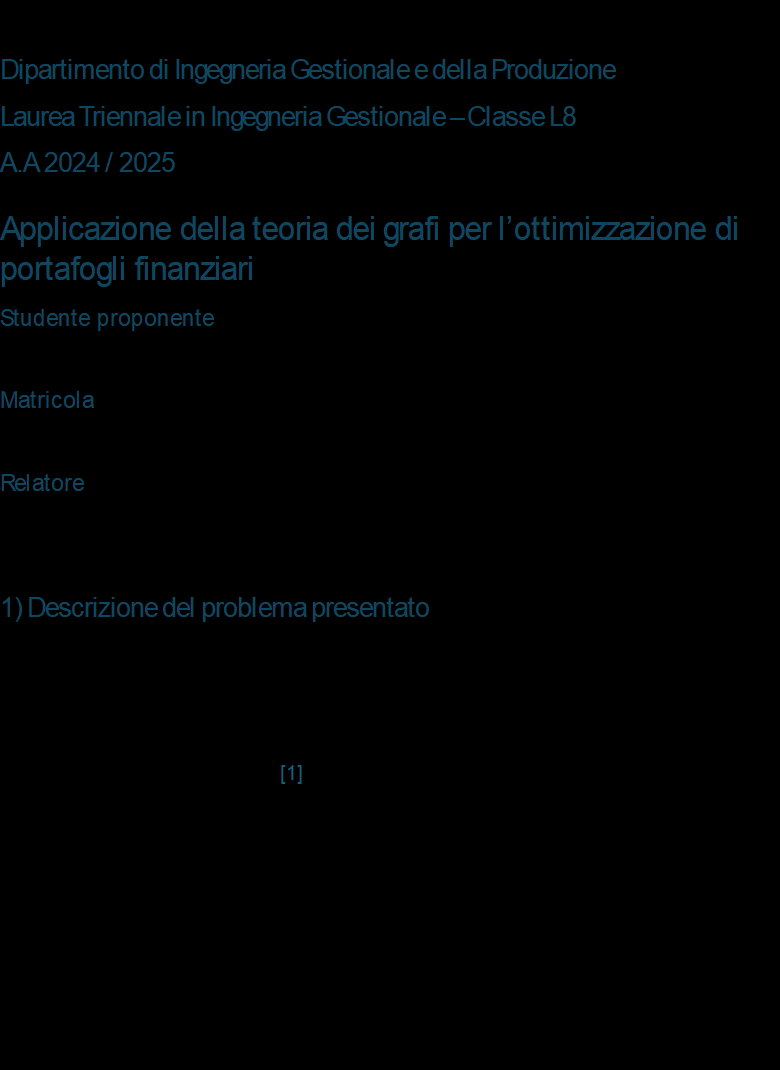